In [1]:
import astropy.io
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import matplotlib.colors as col
import math
import pandas as pd
import time

from astropy.io import fits
from scipy.ndimage import gaussian_filter1d
from scipy.signal import argrelextrema
from math import pi

In [2]:
def progress(file_count, total_files):
    print("\tCount: {}/{}".format(file_count, total_files), end="\r") 
    time.sleep(1)

In [3]:
#This Function Takes FITS data and pixel size to display Jet Length Info
def jet_length(data, pixel_size):
    
    #Creates list of slice sums
    slice_vals = []
    for row in data:
        slice_sum = 0
        for element in row:
            slice_sum += element
        slice_vals.append(slice_sum)
        
    #Creates list of Cumulative Sum values
    cul_vals = []
    movingsum = 0
    for element in slice_vals:
        movingsum += element
        cul_vals.append(movingsum)
        
    #Normalizes the Cumulative Values and creates list
    max_val = cul_vals[-1]
    norm_cul_vals = []
    norm = 0
    for element in cul_vals:
        norm = element / max_val
        norm_cul_vals.append(norm)
        
    #Edits the Normalizes Values to Exclude zeros and repeating terms
    final_reached = False
    norm_cul_vals_edit = []
    for element in norm_cul_vals:
        if element != 0 and final_reached is False:
            norm_cul_vals_edit.append(element)
        if element == 1:
            final_reached = True
        
    #Creates Value Headers for x-axis of histogram
    x_vals = []
    for x in range(len(norm_cul_vals_edit)):
        x_vals.append(x)
        
    x_vals_med = round(len(x_vals) / 2)
    x_vals_Q1 = round(np.median(x_vals[:x_vals_med]))
    x_vals_Q3 = round(np.median(x_vals[x_vals_med:]))
        
    smooth = gaussian_filter1d(norm_cul_vals_edit, 10)
    d1 = np.gradient(smooth)
    smooth_d1 = gaussian_filter1d(d1, 50)
    d2 = np.gradient(smooth_d1)
    smooth_d2 = gaussian_filter1d(d2, 100)
    d3 = np.gradient(smooth_d2)
    smooth_d3 = gaussian_filter1d(d3, 300)
    infls = np.where(np.diff(np.sign(smooth_d2)))[0]
    
    # for local maxima
    maxima_d2 = argrelextrema(smooth_d2, np.greater)
    # for local minima
    minima_d2 = argrelextrema(smooth_d2, np.less)
    
    
    norm_smooth_d1 = smooth_d1 / np.max(smooth_d1)
    norm_smooth_d2 = smooth_d2 / np.max(smooth_d2)
    norm_smooth_d3 = smooth_d3 / np.max(smooth_d3)
    
    #edited normalized cumulative histogram of data
    #plt.plot(x_vals, norm_cul_vals_edit, color='b', label = "raw")
    #plt.plot(norm_smooth_d1, label='1st derivative', color = "g")
    #plt.plot(norm_smooth_d2, label='2nd derivative', color = "orange")
    #plt.plot(norm_smooth_d3, label='3rd derivative', color = "r")
    #labelcount = 0
    #for i, infl in enumerate(infls, 1):
        #if labelcount == 0:
            #plt.axvline(x=infl, color='k', linestyle='dashed', label="Inflection Points")
        #else:
            #plt.axvline(x=infl, color='k', linestyle='dashed')
        #labelcount += 1
        

    min_lst = []
    max_lst = []
    if len(maxima_d2) > 0:
        for element in maxima_d2:
            for index in element:
                try:
                    #plt.axvline(x=index, color='r', linestyle='dashed')
                    max_lst.append(index)
                except ValueError:
                    print("Did not graph: {}".format(index))
    if len(minima_d2) > 0:
        for element in minima_d2:
            for index in element:
                try:
                    #plt.axvline(x=index, color='y', linestyle='dashed')
                    min_lst.append(index)
                except ValueError:
                    print("Did not graph: {}".format(index))
                    
    
    #Determines and prints length of jet in pixels. Estimates to 0.98
    pixel_count = 0
    for element in norm_cul_vals_edit:
        if element >= 0.02 and element <= 0.98:
            pixel_count += 1
    

    #Converts pixel size to cm and prints
    jet_size_cm = pixel_size * pixel_count
    
    
    #Converts cm size to kpc and prints
    jet_size_kpc = round((jet_size_cm * 3.24077928967e-19) / 1e3, 4)
    
    lobe_dist_kpc = 0.0
    

    max_lst = sorted(max_lst)
    min_lst = sorted(min_lst)
    
    if (len(max_lst) + len(min_lst)) > 3:
        try:
            main_max = []
            main_min = []
            for point in max_lst:
                if point > x_vals_med and point < x_vals_Q3:
                    main_max.append(point)
            for point in min_lst:
                if point > x_vals_Q1 and point < x_vals_med:
                    main_min.append(point)



            slice_vals_edit = []
            flag = False
            for element in slice_vals:
                if flag is True:
                    slice_vals_edit.append(element)
                if element != 0 and flag is False:
                    flag = True
                    slice_vals_edit.append(element)

            for i in range(max(main_min), min(main_max)):
                slice_vals_edit[i] = float(0)

            lobe_dist = min(main_max) - max(main_min)

            cul_vals = []
            movingsum = 0
            for element in slice_vals_edit:
                movingsum += element
                cul_vals.append(movingsum)

            #Normalizes the Cumulative Values and creates list
            max_val = cul_vals[-1]
            norm_cul_vals = []
            norm = 0
            for element in cul_vals:
                norm = element / max_val
                norm_cul_vals.append(norm)

            #Edits the Normalizes Values to Exclude zeros and repeating terms
            final_reached = False
            norm_cul_vals_edit = []
            for element in norm_cul_vals:
                if element != 0 and final_reached is False:
                    norm_cul_vals_edit.append(element)
                if element == 1:
                    final_reached = True


            #Determines and prints length of jet in pixels. Estimates to 0.98
            pixel_count = 0
            for element in norm_cul_vals_edit:
                if element >= 0.02 and element <= 0.98:
                    pixel_count += 1

            #Converts pixel size to cm and prints
            jet_size_cm = pixel_size * pixel_count

            #Converts cm size to kpc and prints
            jet_size_kpc = round((jet_size_cm * 3.24077928967e-19) / 1e3, 4)

            #lobe_dist_cm = lobe_dist * pixel_size
            #lobe_dist_kpc = round((lobe_dist_cm * 3.24077928967e-19) / 1e3, 4)
            
        except ValueError:
            p=0
    
    return jet_size_kpc
    

In [4]:
def jet_width(data, width, pixel_size):
    
    #Reorients data so rows become columns
    data_reorient = []
    for x in range(width):
        col_sub = []
        for row in data:
            col_sub.append(row[x])
        data_reorient.append(col_sub)
        
    #Creates list of slice sums
    slice_vals = []
    for row in data_reorient:
        slice_sum = 0
        for element in row:
            slice_sum += element
        slice_vals.append(slice_sum)
        
    #Creates list of Cumulative Sum values
    cul_vals = []
    movingsum = 0
    for element in slice_vals:
        movingsum += element
        cul_vals.append(movingsum)
        
    #Normalizes the Cumulative Values and creates list
    max_val = cul_vals[-1]
    norm_cul_vals = []
    norm = 0
    for element in cul_vals:
        norm = element / max_val
        norm_cul_vals.append(norm)
        
    #Edits the Normalizes Values to Exclude zeros and repeating terms
    final_reached = False
    norm_cul_vals_edit = []
    for element in norm_cul_vals:
        if element != 0 and final_reached is False:
            norm_cul_vals_edit.append(element)
        if element == 1:
            final_reached = True
    
    #Determines and prints length of jet in pixels. Estimates to 0.98
    pixel_count = 0
    for element in norm_cul_vals_edit:
        if element >= 0.02 and element <= 0.98:
            pixel_count += 1

    #Converts pixel size to cm and prints
    jet_size_cm = pixel_size * pixel_count
    
    #Converts cm size to kpc and prints
    jet_size_kpc = round((jet_size_cm * 3.24077928967e-19) / 1e3, 4)
    
    return jet_size_kpc
   

In [5]:
def tenser_finder(data, center_x, center_y):
    moment_sum = np.array([[0, 0],
                           [0, 0]])
    
    for y in range(len(data)):
        for x in range(len(data[y])):
            I = data[y, x]
            
            if I != 0:
                rx = abs(center_x - x)
                ry = abs(center_y - y)

                r2 = (rx**2) + (ry**2)

                loc_array = np.array([[(rx*rx), (rx*ry)],
                                      [(ry*rx), (ry*ry)]])

                Ident = np.identity(2)

                moment = ((2 * I) * loc_array) - ((r2 * I) * Ident)

                moment_sum = moment_sum + moment
            
    return moment_sum
            
            

In [6]:
def circle(dim_x, dim_y, circ_rad):

    zeros_lst = [0] * 1000
    data_circ_lst = []
    
    for i in range(1000):
        data_circ_lst.append(zeros_lst)
        
    data_circ = np.array(data_circ_lst)

    center_x = dim_x / 2
    center_y = dim_y / 2
    
    
    
    moment_sum = np.array([[0, 0],
                           [0, 0]])
    
    for y in range(len(data_circ)):
        for x in range(len(data_circ[y])):
            
            rx = abs(center_x - x)
            ry = abs(center_y - y)

            r2 = (rx**2) + (ry**2)

            loc_array = np.array([[(rx*rx), (rx*ry)],
                                  [(ry*rx), (ry*ry)]])

            Ident = np.identity(2)
            
            if r2 <= circ_rad:
                I = 1
            else:
                I = 0

            moment = ((2 * I) * loc_array) - ((r2 * I) * Ident)

            moment_sum = moment_sum + moment
    
            
    return moment_sum

In [7]:
def elipse(dim_x, dim_y, x_rad, y_rad):
    
    zeros_lst = [0] * 1000
    data_eli_lst = []
    
    for i in range(1000):
        data_eli_lst.append(zeros_lst)
        
    data_eli = np.array(data_eli_lst)
    
    center_x = dim_x / 2
    center_y = dim_y / 2
    
    
    
    moment_sum = np.array([[0, 0],
                           [0, 0]])
    
    for y in range(len(data_eli)):
        for x in range(len(data_eli[y])):
           
            ellipse_eq = (((x - center_x)**2) / (x_rad**2)) + (((y - center_y)**2) / (y_rad**2))
            
            if ellipse_eq <= 1:
                I = 1 
                
                rx = abs(center_x - x)
                ry = abs(center_y - y)

                r2 = (rx**2) + (ry**2)

                loc_array = np.array([[(rx*rx), (rx*ry)],
                                      [(ry*rx), (ry*ry)]])

                Ident = np.identity(2) 
                
                moment = ((2 * I) * loc_array) - ((r2 * I) * Ident)

                moment_sum = moment_sum + moment
                
            else:
                I = 0

           
            
    return moment_sum

In [8]:
#Main Calling Block of Code

print("\nTENSOR COMPUTING PROGRAM:")
print("{}\n".format("_"*100))

#years = [1.0, 2.0, 4.0, 8.0, 16.0, 32.0, 64.0, 121.2, 256.1, 513.1, 773.1]
#jet_dim_data = np.array([["Jet Strength (L)", "Sim Time (Myr)", "Jet Length (kpc)", "Luminosity (ergs/s/Hz)"]])


path = '**/Group_L446*_rc30_*nu=30.0*Myr.fits*'

# Determines if there are any files in device
total_files = len(glob.glob(path, recursive=True))

if total_files > 0:
    
    file_count = 0
    ratio_lst = []
    sim_time_lst = []
    sim_eli_ratios = []
    color_cycle = []
    
    
    
    for file in sorted(glob.glob(path, recursive=True)):

        file_count += 1
                                             
        try:
            print("{}\n".format("_"*100))
            print("File Number {}/{}\n".format(file_count, total_files))
            print("File Name: {}".format(file))
            
            fits_image_hdul = fits.open(file)
            

            #Displays FITS Image title, time index, and pixel size
            sim_title = fits_image_hdul[0].header['OBJECT']
            sim_time = fits_image_hdul[0].header['TIME']
            sim_time = round(float(sim_time[:-4]), 1)
            print("Simulation Title: {}".format(sim_title))
            print("Time index: {}".format(sim_time))
            
            sim_time_lst.append(sim_time)

            pixel = fits_image_hdul[0].header['CDELT1']
            pixel_size = float(pixel[:-3])
            
            center_x = float(fits_image_hdul[0].header['CRPIX1'])
            center_y = float(fits_image_hdul[0].header['CRPIX2'])
            center = (center_x, center_y)
            print("Center of fits image: {}".format(center))

            #Difines Data From FITS image and records image dimensions
            data = fits_image_hdul[0].data
            length = len(data[0])
            width = len(data)
            print("FITS Image Dimensions: {}x{} pixels \n".format(length, width))
            
            
            if "0.00_1.00_0.00" in file:
                color_cycle.append("teal")
            elif "0.00_0.87_0.50" in file:
                color_cycle.append("yellow")
            elif "0.00_0.50_0.87" in file:
                color_cycle.append("purple")
            elif "0.00_0.00_1.00" in file:
                color_cycle.append("pink")
            else:
                print("BROKEN")
            
            jet_len = jet_length(data, pixel_size)
            jet_wid = jet_width(data, width, pixel_size)
            
            wid_len_ratio = jet_wid / jet_len
            sim_eli_ratios.append(wid_len_ratio)
            
            
            moment = tenser_finder(data, center_x, center_y)
            xy = moment[0, 1]
            yy = moment[1, 1]

            ratio = xy/yy
            ratio_lst.append(ratio)
            
            print("Quadrupole Tensor: ")
            print(moment)
            print("\n")

            #file_data = np.array([jet_stren, float(sim_time), jet_len, luminosity])
            #jet_dim_data = np.vstack([jet_dim_data, file_data])

            #print("{}\n".format("_"*100))
            

        except OSError:
            print("Error with file: {}".format(file))
            print("Empty or corrupt FITS file")

    print(ratio_lst)

else:
    print("ERROR: Could not find any necessary files on your device")
    print("Program intakes files of the name: {}".format(path))
        
#data_table = pd.DataFrame(jet_dim_data)
        
#print(data_table)
#with open("nop.npy", "wb") as open_file:
        #np.save(open_file, jet_dim_data)


TENSOR COMPUTING PROGRAM:
____________________________________________________________________________________________________

____________________________________________________________________________________________________

File Number 1/44

File Name: Jet Simulation Data/Group_L446_rc30_beta07/nu=30.0MHz/Group_L446_rc30_beta07_0010_nu=30.0_los=0.00_0.00_1.00_1.0Myr.fits.gz
Simulation Title: Simulation Group_L446_rc30_beta07 - 1.0 Myr - 30 MHz
Time index: 1.0
Center of fits image: (8.5, 8.5)
FITS Image Dimensions: 16x16 pixels 

Quadrupole Tensor: 
[[ -342.18533562 67843.48198254]
 [67843.48198254   342.18533562]]


____________________________________________________________________________________________________

File Number 2/44

File Name: Jet Simulation Data/Group_L446_rc30_beta07/nu=30.0MHz/Group_L446_rc30_beta07_0010_nu=30.0_los=0.00_0.50_0.87_1.0Myr.fits.gz
Simulation Title: Simulation Group_L446_rc30_beta07 - 1.0 Myr - 30 MHz
Time index: 1.0
Center of fits image: (8.5,

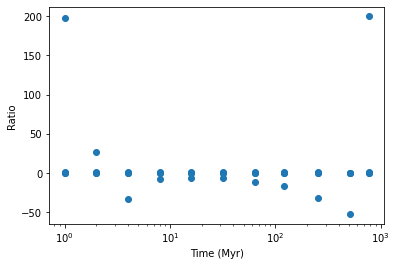

In [9]:
plt.scatter(sim_time_lst, ratio_lst)
plt.xscale("log")
plt.xlabel("Time (Myr)")
plt.ylabel("Ratio")
plt.show()

In [10]:
#def circle(dim_x, dim_y, circ_rad):


dim_x = 1000
dim_y = 1000
circ_rad_lst = [100, 200, 300, 400, 500, 600]
ratio_lst_circ = []


for circ_rad in circ_rad_lst:
    
    moment = circle(dim_x, dim_y, circ_rad)
    xy = moment[0, 1]
    yy = moment[1, 1]
    #ratio = xy/yy
    #ratio_lst_circ.append(ratio)

    print("Quadrupole Tensor for r={}: ".format(circ_rad))
    print(moment)
    print("\n")

#plt.scatter(circ_rad_lst, ratio_lst_circ)

Quadrupole Tensor for r=100: 
[[    0. 10400.]
 [10400.     0.]]


Quadrupole Tensor for r=200: 
[[    0. 39704.]
 [39704.     0.]]


Quadrupole Tensor for r=300: 
[[    0. 90368.]
 [90368.     0.]]


Quadrupole Tensor for r=400: 
[[     0. 161720.]
 [161720.      0.]]


Quadrupole Tensor for r=500: 
[[     0. 251280.]
 [251280.      0.]]


Quadrupole Tensor for r=600: 
[[     0. 359176.]
 [359176.      0.]]




Quadrupole Tensor for rx=100, ry=100: 
[[0.00000000e+00 1.00130632e+08]
 [1.00130632e+08 0.00000000e+00]]


Quadrupole Tensor for rx=100, ry=200: 
[[-4.71297784e+08  3.99981416e+08]
 [ 3.99981416e+08  4.71297784e+08]]


Quadrupole Tensor for rx=100, ry=300: 
[[-1.88557918e+09  8.99981200e+08]
 [ 8.99981200e+08  1.88557918e+09]]


Quadrupole Tensor for rx=100, ry=400: 
[[-4.71378018e+09  1.60013102e+09]
 [ 1.60013102e+09  4.71378018e+09]]


Quadrupole Tensor for rx=100, ry=500: 
[[-9.42246818e+09  2.49969174e+09]
 [ 2.49969174e+09  9.42246818e+09]]


Quadrupole Tensor for rx=200, ry=100: 
[[ 4.71297784e+08  3.99981416e+08]
 [ 3.99981416e+08 -4.71297784e+08]]


Quadrupole Tensor for rx=200, ry=200: 
[[0.00000000e+00 1.59971758e+09]
 [1.59971758e+09 0.00000000e+00]]


Quadrupole Tensor for rx=200, ry=300: 
[[-2.35657540e+09  3.59947346e+09]
 [ 3.59947346e+09  2.35657540e+09]]


Quadrupole Tensor for rx=200, ry=400: 
[[-7.54025579e+09  6.40003395e+09]
 [ 6.40003395e+09  7.54025579e+09]]




Text(0.5, 1.0, 'Ellipse Tensor Data')

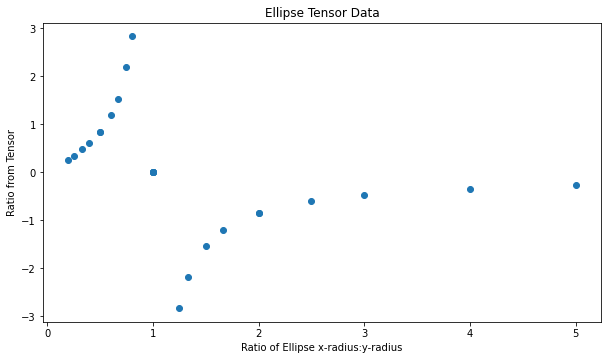

In [11]:
plt.rcParams["figure.figsize"] = (10,5.5)

#def elipse(dim_x, dim_y, x_rad, y_rad):

dim_x = 1000
dim_y = 1000
x_rad_lst = [100, 200, 300, 400, 500]
y_rad_lst = [100, 200, 300, 400, 500]
ratio_lst_eli = []
xy_ratio_lst = []


for x_rad in x_rad_lst:
    for y_rad in y_rad_lst:
    
        xy_ratio = x_rad / y_rad
        xy_ratio_lst.append(xy_ratio)
        
        moment = elipse(dim_x, dim_y, x_rad, y_rad)
        xy = moment[0, 1]
        yy = moment[1, 1]
        
        if yy == 0:
            ratio_lst_eli.append(0)
        else:
            ratio = xy/yy
            ratio_lst_eli.append(ratio)

        print("Quadrupole Tensor for rx={}, ry={}: ".format(x_rad, y_rad))
        print(moment)
        print("\n")
        

plt.scatter(xy_ratio_lst, ratio_lst_eli)
plt.xlabel("Ratio of Ellipse x-radius:y-radius")
plt.ylabel("Ratio from Tensor")
plt.title("Ellipse Tensor Data")

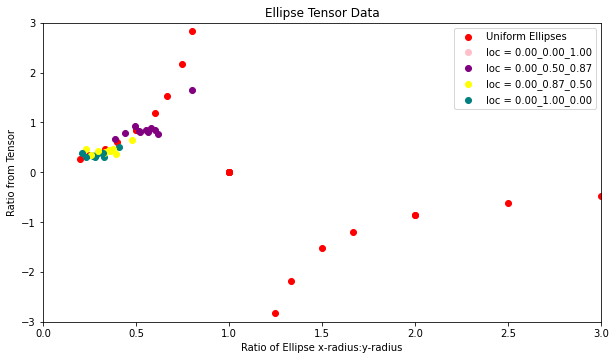

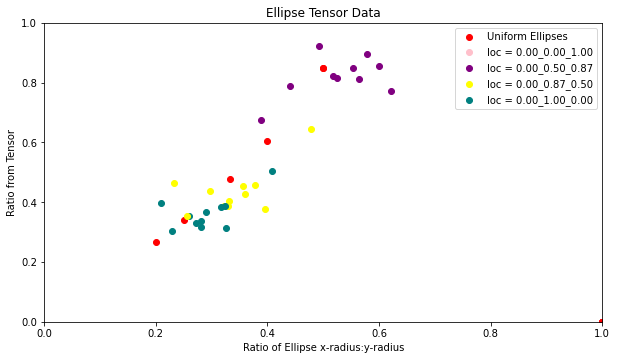

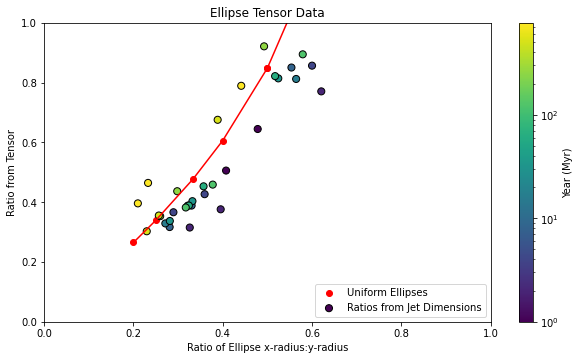

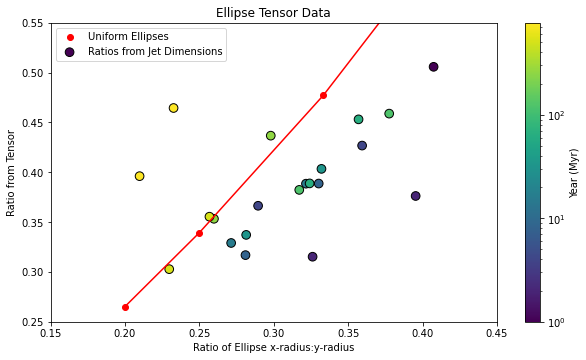

In [16]:

color_key = {"teal": "0.00_1.00_0.00", "yellow": "0.00_0.87_0.50", "purple": "0.00_0.50_0.87", "pink": "0.00_0.00_1.00"}

plt.scatter(xy_ratio_lst, ratio_lst_eli, label="Uniform Ellipses", color = "red")

prev_color = []
prev_color.append(color_cycle[0])

plt.scatter(sim_eli_ratios[0], ratio_lst[0], label="loc = {}".format(color_key[color_cycle[0]]), color = color_cycle[0])

for i in range(1, len(sim_eli_ratios)):
    if color_cycle[i] not in prev_color:
        plt.scatter(sim_eli_ratios[i], ratio_lst[i], label="loc = {}".format(color_key[color_cycle[i]]), color = color_cycle[i])
        prev_color.append(color_cycle[i])
    else:
        plt.scatter(sim_eli_ratios[i], ratio_lst[i], color = color_cycle[i])
        
plt.legend()
plt.xlabel("Ratio of Ellipse x-radius:y-radius")
plt.ylabel("Ratio from Tensor")
plt.title("Ellipse Tensor Data")
plt.xlim([0, 3])
plt.ylim([-3, 3])

plt.show()

plt.scatter(xy_ratio_lst, ratio_lst_eli, label="Uniform Ellipses", color = "red")

prev_color = []
prev_color.append(color_cycle[0])

plt.scatter(sim_eli_ratios[0], ratio_lst[0], label="loc = {}".format(color_key[color_cycle[0]]), color = color_cycle[0])

for i in range(1, len(sim_eli_ratios)):
    if color_cycle[i] not in prev_color:
        plt.scatter(sim_eli_ratios[i], ratio_lst[i], label="loc = {}".format(color_key[color_cycle[i]]), color = color_cycle[i])
        prev_color.append(color_cycle[i])
    else:
        plt.scatter(sim_eli_ratios[i], ratio_lst[i], color = color_cycle[i])
        
plt.legend()
plt.xlabel("Ratio of Ellipse x-radius:y-radius")
plt.ylabel("Ratio from Tensor")
plt.title("Ellipse Tensor Data")
plt.xlim([0, 1])
plt.ylim([0, 1])

plt.show()



short_xy_ratios = []
short_eli_ratios = []
for i in range(len(xy_ratio_lst)):
    if xy_ratio_lst[i] < 1:
        short_xy_ratios.append(xy_ratio_lst[i])
        short_eli_ratios.append(ratio_lst_eli[i])
        
short_xy_ratios = sorted(short_xy_ratios)
short_eli_ratios = sorted(short_eli_ratios)

plt.scatter(short_xy_ratios, short_eli_ratios, label="Uniform Ellipses", color = "red")
plt.plot(short_xy_ratios, short_eli_ratios, color = "red")
plt.scatter(sim_eli_ratios, ratio_lst, label="Ratios from Jet Dimensions", c=sim_time_lst, norm=col.LogNorm(), s=50, edgecolors = 'k')
plt.colorbar(label = "Year (Myr)")
plt.set_cmap("viridis") 
plt.legend(loc="lower right")
plt.xlabel("Ratio of Ellipse x-radius:y-radius")
plt.ylabel("Ratio from Tensor")
plt.title("Ellipse Tensor Data")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.show()


plt.scatter(short_xy_ratios, short_eli_ratios, label="Uniform Ellipses", color = "red")
plt.plot(short_xy_ratios, short_eli_ratios, color = "red")
plt.scatter(sim_eli_ratios, ratio_lst, label="Ratios from Jet Dimensions", c=sim_time_lst, norm=col.LogNorm(), s=75, edgecolors = 'k')
plt.colorbar(label = "Year (Myr)")
plt.set_cmap("viridis") 
plt.legend()
plt.xlabel("Ratio of Ellipse x-radius:y-radius")
plt.ylabel("Ratio from Tensor")
plt.title("Ellipse Tensor Data")
plt.xlim([0.15, 0.45])
plt.ylim([0.25, 0.55])
plt.show()